In [1]:
from sklearn.model_selection import train_test_split
from datasets import load_dataset,DatasetDict
from evaluate import load as load_metric
import numpy as np
import matplotlib.pyplot as plt



In [2]:
dataset=load_dataset("cifar10")

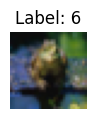

In [13]:
first_image = dataset['train'][100]['img']
first_label = dataset['train'][100]['label']

# Display the image
plt.figure(figsize=(1, 1))  # 1 inch x 1 inch for 32x32 pixels
plt.imshow(first_image)
plt.title(f'Label: {first_label}')
plt.axis('off')
plt.show()


In [14]:
print(dataset['train'][1])

{'img': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32 at 0x75A9BCD6DEE0>, 'label': 6}


In [5]:
ds=dataset['train'].train_test_split(test_size=0.3,stratify_by_column="label")
ds_test=dataset["test"].train_test_split(test_size=0.5,stratify_by_column="label")
ds_train_reduced = ds["train"].train_test_split(test_size=0.7, stratify_by_column="label")["train"]

ds=DatasetDict({
    'train':ds_train_reduced,
    "test":ds_test["test"],
    "valid":ds_test["train"]
    
})


del ds_test

In [6]:
print(ds)
ds.shape

DatasetDict({
    train: Dataset({
        features: ['img', 'label'],
        num_rows: 10500
    })
    test: Dataset({
        features: ['img', 'label'],
        num_rows: 5000
    })
    valid: Dataset({
        features: ['img', 'label'],
        num_rows: 5000
    })
})


{'train': (10500, 2), 'test': (5000, 2), 'valid': (5000, 2)}

In [7]:
labels=ds["train"].features['label']
labels

ClassLabel(names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'], id=None)

In [8]:
from transformers import AutoImageProcessor,ViTForImageClassification

model_name_or_path='google/vit-base-patch16-224-in21k'

processor=AutoImageProcessor.from_pretrained(model_name_or_path,use_fast=True)
model=ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels.names),
    id2label={str(i): c for i, c in enumerate(labels.names)},
    label2id={c:str(i) for i,c in enumerate(labels.names)},
    ignore_mismatched_sizes=True
)



Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
from PIL import Image
import torchvision.transforms as transforms
import torch
import numpy as np

def transform(example_batch):
    transform = transforms.Resize((224, 224)) 

    resized_images = [transform(x.convert("RGB")) for x in example_batch['img']]

    inputs=processor(resized_images,return_tensors='pt')

    inputs['label']=example_batch['label']

    return inputs


prepared_ds=ds.with_transform(transform)


def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['label'] for x in batch])
    }


metric=load_metric("accuracy")

def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)




In [10]:
from transformers import TrainingArguments

root_dir = "ViT_custom/"  # Path where all config files and checkpoints will be saved
training_args = TrainingArguments(
  output_dir=root_dir,
  per_device_train_batch_size=16,
  evaluation_strategy="epoch",
  save_strategy="epoch",
  fp16=True,
  num_train_epochs=1,
  logging_steps=500,
  learning_rate=2e-4,
  save_total_limit=1,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
)

/home/adi_techbuddy/anaconda3/envs/torchenv/lib/python3.8/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [11]:
print(prepared_ds.shape)

{'train': (10500, 2), 'test': (5000, 2), 'valid': (5000, 2)}


In [12]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_ds["train"],
    eval_dataset=prepared_ds["valid"],
    tokenizer=processor,
)

In [13]:
save_dir = 'ViT_custom/best_model/'  # Define the path to save the model
train_results = trainer.train()


  0%|          | 0/657 [00:00<?, ?it/s]

{'loss': 0.3889, 'grad_norm': 5.049904823303223, 'learning_rate': 4.779299847792998e-05, 'epoch': 0.76}


  0%|          | 0/625 [00:00<?, ?it/s]

{'eval_loss': 0.11070407927036285, 'eval_accuracy': 0.974, 'eval_runtime': 668.1593, 'eval_samples_per_second': 7.483, 'eval_steps_per_second': 0.935, 'epoch': 1.0}
{'train_runtime': 4671.2641, 'train_samples_per_second': 2.248, 'train_steps_per_second': 0.141, 'train_loss': 0.3257586596763297, 'epoch': 1.0}


In [14]:
trainer.save_model(save_dir)  # Save the best model
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

***** train metrics *****
  epoch                    =         1.0
  total_flos               = 757839746GF
  train_loss               =      0.3258
  train_runtime            =  1:17:51.26
  train_samples_per_second =       2.248
  train_steps_per_second   =       0.141


In [15]:
import torch

# Get the total and available memory in MB
total_memory = torch.cuda.get_device_properties(0).total_memory / 1024 ** 2  # Convert from bytes to MB
allocated_memory = torch.cuda.memory_allocated(0) / 1024 ** 2
free_memory = torch.cuda.memory_reserved(0) / 1024 ** 2 - allocated_memory

print(f"Total GPU memory: {total_memory:.2f} MB")
print(f"Allocated memory: {allocated_memory:.2f} MB")
print(f"Free memory: {free_memory:.2f} MB")


Total GPU memory: 3906.44 MB
Allocated memory: 998.79 MB
Free memory: 1529.21 MB


In [16]:
metrics = trainer.evaluate(prepared_ds['test'])
trainer.log_metrics("test", metrics)
trainer.save_metrics("test", metrics)

  0%|          | 0/625 [00:00<?, ?it/s]

***** test metrics *****
  epoch                   =        1.0
  eval_accuracy           =     0.9714
  eval_loss               =     0.1116
  eval_runtime            = 0:10:49.39
  eval_samples_per_second =        7.7
  eval_steps_per_second   =      0.962


  0%|          | 0/625 [00:00<?, ?it/s]

Recall for airplane: 0.98
Recall for automobile: 0.99
Recall for bird: 0.97
Recall for cat: 0.95
Recall for deer: 0.96
Recall for dog: 0.95
Recall for frog: 0.98
Recall for horse: 0.98
Recall for ship: 0.99
Recall for truck: 0.97


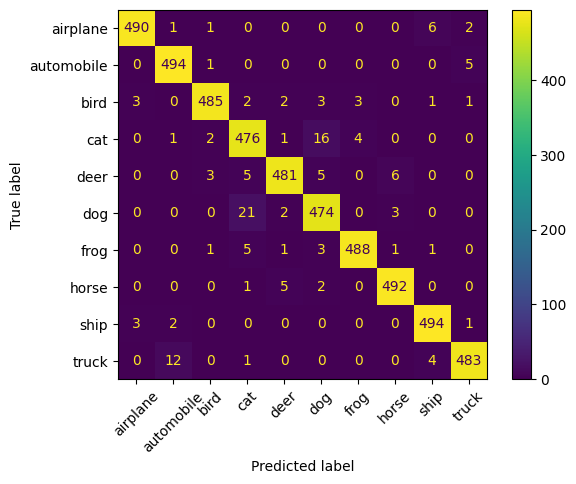

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score

test_ds = ds['test'].with_transform(transform)
test_outputs = trainer.predict(test_ds)

y_true = test_outputs.label_ids
y_pred = test_outputs.predictions.argmax(1)

labels = test_ds.features["label"].names
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)

recall = recall_score(y_true, y_pred, average=None)

# Print the recall for each class
for label, score in zip(labels, recall):
  print(f"Recall for {label}: {score:.2f}")

In [31]:
from transformers import pipeline
import cv2

In [40]:
def getPrediction(image):
    image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    model_name_or_path = 'google/vit-base-patch16-224-in21k'
    processor = AutoImageProcessor.from_pretrained(model_name_or_path,use_fast=True)
    vit = ViTForImageClassification.from_pretrained(save_dir)
    model = pipeline('image-classification', model=vit, feature_extractor=processor,device=0)
    
    result = model(image,top_k=1)
    return result

In [3]:
import cv2

image = cv2.imread("sample/i1.png")
# print(getPrediction(image))

In [4]:
print(image)

[[[182  88  42]
  [183  89  43]
  [184  92  45]
  ...
  [193  94  50]
  [194  95  51]
  [194  95  51]]

 [[183  89  43]
  [183  89  43]
  [183  91  44]
  ...
  [193  96  52]
  [193  96  52]
  [193  96  52]]

 [[183  87  41]
  [181  87  41]
  [180  88  41]
  ...
  [194  97  53]
  [194  97  53]
  [194  97  53]]

 ...

 [[204 170 140]
  [205 171 142]
  [204 171 145]
  ...
  [230 202 178]
  [230 202 178]
  [230 202 178]]

 [[204 170 140]
  [205 171 141]
  [204 172 143]
  ...
  [230 202 178]
  [230 202 178]
  [230 202 178]]

 [[206 170 140]
  [204 170 140]
  [204 172 143]
  ...
  [229 202 176]
  [229 202 176]
  [229 202 176]]]
